In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

def sample_imbalanced(data, labels, num_samples):
    num_samples_per_digit = np.exp(np.random.randn(10))
    num_samples_per_digit = num_samples_per_digit / num_samples_per_digit.sum()
    num_samples_per_digit = np.floor(num_samples_per_digit * num_samples).astype(int)
    sampled_data = []
    sampled_labels = []
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        sampled_indices = np.random.choice(digit_indices, num_samples_per_digit[digit], replace=False)
        sampled_data.append(data[sampled_indices])
        sampled_labels.append(labels[sampled_indices])
    return np.concatenate(sampled_data), np.concatenate(sampled_labels).flatten()

def sample(data, labels, num_samples_per_digit):
    sampled_data = []
    sampled_labels = []
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        sampled_indices = np.random.choice(digit_indices, num_samples_per_digit, replace=False)
        sampled_data.append(data[sampled_indices])
        sampled_labels.append(labels[sampled_indices])
    return np.concatenate(sampled_data), np.concatenate(sampled_labels).flatten()

# Data prep

## Load

In [2]:
from tensorflow.keras.datasets import mnist

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (60000, 28, 28, 1)
X_test.shape:  (10000, 28, 28, 1)


## Create imbalanced subsample

In [3]:
# Define how many samples of each digit to include
train_samples = 10000

# Sample the training data
X_train, y_train = sample_imbalanced(X_train, y_train, train_samples)

test_samples_per_class = 250

# Sample the testing data
X_test, y_test = sample(X_test, y_test, test_samples_per_class)

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train counts: ", np.bincount(y_train))

X_train.shape: (9995, 28, 28, 1)
X_test.shape:  (2500, 28, 28, 1)
y_train counts:  [3284 1074 1264  583  561  201  459  412  654 1503]


## Oversample to balance

In [4]:
from imblearn.over_sampling import RandomOverSampler

def oversample_with_imblearn(X, y):
    # Get original shape
    N, H, W, C = X.shape

    # Flatten for imblearn (samples, features)
    X_flat = X.reshape(N, -1)

    # Create oversampler
    ros = RandomOverSampler()

    # Perform oversampling
    X_res, y_res = ros.fit_resample(X_flat, y)

    # Reshape back to image form
    X_res = X_res.reshape(-1, H, W, C)

    return X_res, y_res

In [5]:
X_train_bal, y_train_bal = oversample_with_imblearn(X_train, y_train)

print("Before balancing:", np.bincount(y_train))
print("After balancing: ", np.bincount(y_train_bal))

Before balancing: [3284 1074 1264  583  561  201  459  412  654 1503]
After balancing:  [3284 3284 3284 3284 3284 3284 3284 3284 3284 3284]


## Create/train/analyze model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dropout_rate = 0.25

n_classes  = np.unique(y_train_bal).shape[0]

# Create model
model = Sequential([
    Input(shape=X_train_bal.shape[1:]),

    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),
    
    GlobalAveragePooling2D(),
    
    Dense(n_classes, activation='softmax'),
])

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.01)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,314 (24.66 KB)

 Trainable params: 6,266 (24.48 KB)

 Non-trainable params: 48 (192.00 B)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image generator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=10,      # Rotate images randomly
    width_shift_range=0.1,  # Randomly shift the width of images
    height_shift_range=0.1, # Randomly shift the height of images
    zoom_range=0.2,         # Randomly zoom
)

In [8]:
history = model.fit(
    datagen.flow(
        X_train, y_train,
        batch_size=512,
        shuffle=True,
        ),
    epochs=10,
    validation_data=datagen.flow(
        X_test, y_test
        ),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.4614 - loss: 1.7171 - val_accuracy: 0.1332 - val_loss: 16.8291
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7210 - loss: 0.8661 - val_accuracy: 0.3372 - val_loss: 7.3579
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8027 - loss: 0.6296 - val_accuracy: 0.4764 - val_loss: 2.8927
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8575 - loss: 0.4622 - val_accuracy: 0.6752 - val_loss: 1.1163
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8842 - loss: 0.3981 - val_accuracy: 0.7456 - val_loss: 0.8550
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8994 - loss: 0.3259 - val_accuracy: 0.8748 - val_loss: 0.4063
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9098 - loss: 0.3004 - val_accuracy: 0.8848 - val_loss: 0.3680
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9133 - loss: 0.2881 - val_accuracy: 0

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


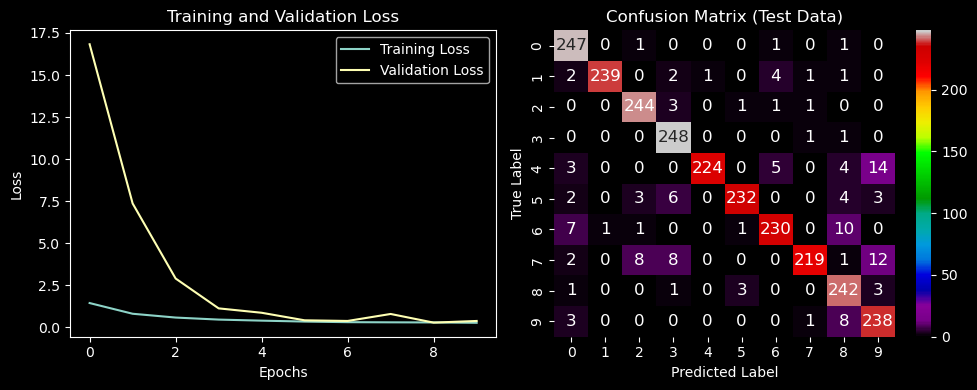

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       250
           1       1.00      0.96      0.98       250
           2       0.95      0.98      0.96       250
           3       0.93      0.99      0.96       250
           4       1.00      0.90      0.94       250
           5       0.98      0.93      0.95       250
           6       0.95      0.92      0.94       250
           7       0.98      0.88      0.93       250
           8       0.89      0.97      0.93       250
           9       0.88      0.95      0.92       250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_test_pred  = model.predict(X_test).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)